# SBA Probability of Default

In [42]:
import numpy as np
import pandas as pd
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# creates a custom data parser before load data (uses SAS timestamp)
custom_date_parser = lambda x: pd.to_datetime(pd.to_numeric(x), origin='1960-01-01', unit='D')

# load the data into a dataframe
df = pd.read_csv('./data/SBAcase.11.13.17.csv', 
                 parse_dates=['ApprovalDate', 'DisbursementDate', 'ChgOffDate'], 
                 date_parser=custom_date_parser)

## 01. Exploratory Data Analysis

In [44]:
# check the shape
df.shape

(2102, 35)

In [45]:
# check for missing values
df.isnull().mean().sort_values(ascending=False)

ChgOffDate           0.668411
LowDoc               0.001427
xx                   0.001427
DisbursementDate     0.001427
Bank                 0.001427
BankState            0.001427
RevLineCr            0.000951
NewExist             0.000476
ChgOffPrinGr         0.000000
DisbursementGross    0.000000
BalanceGross         0.000000
MIS_Status           0.000000
Selected             0.000000
GrAppv               0.000000
New                  0.000000
RealEstate           0.000000
Portion              0.000000
Recession            0.000000
daysterm             0.000000
SBA_Appv             0.000000
UrbanRural           0.000000
LoanNr_ChkDgt        0.000000
FranchiseCode        0.000000
RetainedJob          0.000000
CreateJob            0.000000
NoEmp                0.000000
Term                 0.000000
ApprovalFY           0.000000
ApprovalDate         0.000000
NAICS                0.000000
Zip                  0.000000
State                0.000000
City                 0.000000
Name      

ChgOffDate is expected to have missing values. The ones without date (missing) are the contracts paid in full. Let's check other variables with missing.

In [46]:
pd.options.display.max_columns = None
df[df.drop('ChgOffDate', axis=1).isnull().any(axis=1)]

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
1004,0,3341713002,SPOTLIGHT VIDEO,WESTMINSTER,CA,92683,NaN,NaN,532230,1988-11-23,1989,120,4,1.0,0,0,0,0,N,N,NaT,1989-01-31,80000,0,P I F,0,80000,70240,0,0,0.878,0,3600,14223.0,0
1017,1,3406645010,STREET RODS & EXOTIC CAR RENTA,RANCHO SANTA MARGARITA,CA,92688,"SUPERIOR FINANCIAL GROUP, LLC",CA,532111,2009-05-04,2009,99,7,2.0,5,7,0,1,N,NaN,2011-09-20,2009-05-31,7500,0,CHGOFF,6706,7500,6750,1,0,0.900,0,2970,21018.0,1
1062,1,3685063001,LEADER VIDEO NETWORK 351,MIRA LOMA,CA,91752,NaN,NaN,532230,1989-12-21,1990,120,1,1.0,0,0,1,0,N,N,NaT,1990-01-31,60000,0,P I F,0,60000,54000,0,0,0.900,0,3600,14588.0,0
1114,0,4014285004,Kenneth L. Ching,Fair Oaks,CA,95628,SAFE CU,CA,531210,2010-04-06,2010,84,4,1.0,2,4,0,1,Y,NaN,NaT,2010-04-06,35000,0,P I F,0,35000,31500,0,0,0.900,0,2520,20878.0,0
1124,1,4066645007,LOCATE GREEN HOMES LLC,TURLOCK,CA,95380,"SUPERIOR FINANCIAL GROUP, LLC",CA,531390,2010-05-06,2010,85,2,2.0,2,2,0,1,N,NaN,2013-08-30,2010-05-06,5000,0,P I F,4146,5000,4500,1,0,0.900,0,2550,20938.0,0
1146,0,4178955000,"Improta, Inc.",SANTA MONICA,CA,90403,JPMORGAN CHASE BANK NATL ASSOC,IL,531210,2010-07-23,2010,84,2,NaN,1,2,0,1,Y,N,NaT,2010-08-01,15003,0,P I F,0,10000,5000,0,0,0.500,0,2520,20995.0,0
1204,0,4429443003,COURTESY AUTO RENTAL OF CHULA,SAN DIEGO,CA,91910,NaN,NaN,532111,1991-04-15,1991,60,1,1.0,0,0,1,0,N,N,NaT,1991-07-31,288000,0,P I F,0,288000,244800,0,0,0.850,0,1800,13334.0,0
1255,0,4910065006,Elite Cooling,HUNTINGTON BEACH,CA,92647,JPMORGAN CHASE BANK NATL ASSOC,IL,532210,2011-10-11,2012,84,1,1.0,0,0,0,1,Y,N,NaT,NaT,14915,0,P I F,0,10000,5000,0,0,0.500,0,2520,NaN,0
1691,1,7253454001,UNITY ESCROW INC,ARTESIA,CA,90701,BBCN BANK,CA,531390,2004-03-10,2004,12,13,1.0,2,15,1,1,Y,N,NaT,NaT,100000,0,P I F,0,100000,50000,0,0,0.500,0,360,NaN,0
1858,0,8132923002,"MOVIE MOVERS,ET AL",VAN NUYS,CA,91405,"CITIBANK, N.A.",CA,532120,1995-03-01,1995,120,25,1.0,0,0,1,0,NaN,N,NaT,1995-04-30,700000,0,P I F,0,700000,595000,0,0,0.850,0,3600,16503.0,0


As we have only 12 rows with NaN values (excluding the 'ChgOffDate' column) ~0.6% of the data, I decided to drop those rows.

In [47]:
cols_to_look = list(df.columns)
cols_to_look.remove('ChgOffDate')

df = df.dropna(subset=cols_to_look)

In [48]:
# check for constant variables
df.nunique().sort_values()

State                   1
BalanceGross            1
Selected                2
Recession               2
RealEstate              2
New                     2
MIS_Status              2
Default                 2
UrbanRural              3
NewExist                3
RevLineCr               4
LowDoc                  5
BankState              21
ApprovalFY             23
NAICS                  24
Portion                30
FranchiseCode          33
CreateJob              43
RetainedJob            62
NoEmp                  83
Bank                  154
daysterm              170
Term                  170
DisbursementDate      319
ChgOffDate            501
City                  516
ChgOffPrinGr          613
GrAppv                658
SBA_Appv              752
Zip                   809
DisbursementGross    1179
xx                   1206
ApprovalDate         1357
Name                 1993
LoanNr_ChkDgt        2090
dtype: int64

In [49]:
# drop the columns with unique values
df = df.drop(['State', 'BalanceGross'], axis=1)

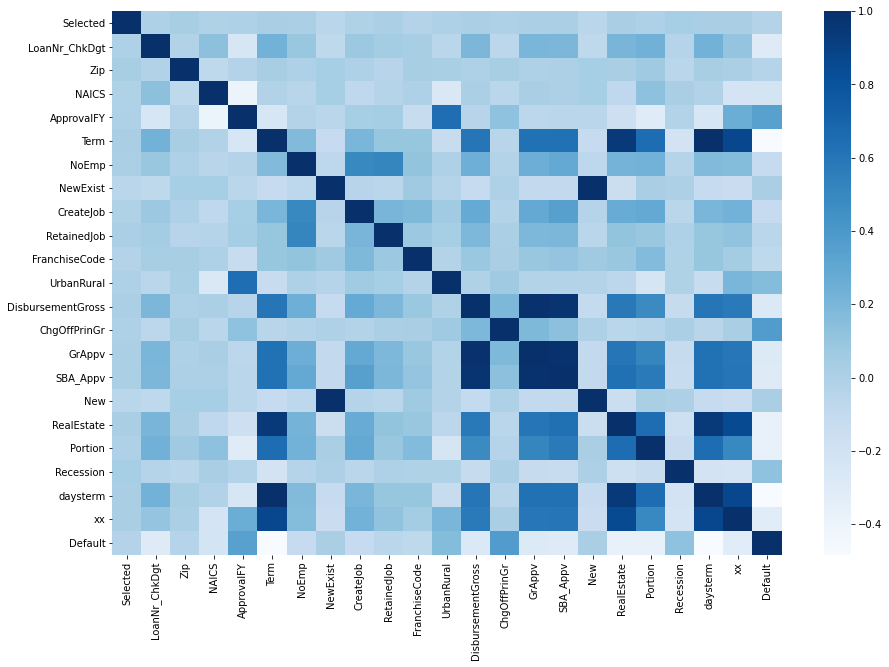

In [52]:
# check correlations
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap='Blues');

In [ ]:
# check outliers